In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632

In [2]:
# annotation_file = Path("./birdclef-2022/train_metadata.csv")
annotation_file = Path("./train_folds.csv")

data_dir = Path("./birdclef-2022/spectograms_v2/")

dataframe = pd.read_csv(annotation_file)
dataframe.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename,file_path,kfold
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg,birdclef-2022/train_audio/afrsil1/XC125458.ogg,0
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg,birdclef-2022/train_audio/afrsil1/XC175522.ogg,0
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg,birdclef-2022/train_audio/afrsil1/XC177993.ogg,1
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg,birdclef-2022/train_audio/afrsil1/XC205893.ogg,4
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg,birdclef-2022/train_audio/afrsil1/XC207431.ogg,4


## loading data

In [3]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, data_dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(annotations_file)
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = data_dir / (self.labels.iloc[idx].filename[:-4] + ".npy")
        spect = np.load(img_path)
        label = self.labels.iloc[idx].primary_label
        if self.transform:
            spect = self.transform(spect)
            # spect.transpose_(0, 2).transpose_(0, 1)
        if self.target_transform:
            label = self.target_transform([label])
        return spect, label

In [4]:
class OneHotEncoder():
  def __init__(self, classes):
    self.num_classes = len(classes)
    self.classes = {}
    for i, c in enumerate(classes):
      self.classes[c] = i

  def transform(self, vals):
    xs = []
    for val in vals:
      x = np.zeros(self.num_classes)
      x[self.classes[val]] = 1
      xs.append(x)
    return xs

classes = list("abcd")
encoder = OneHotEncoder(classes)
encoder.transform("b")

[array([0., 1., 0., 0.])]

In [5]:
from sklearn.preprocessing import LabelEncoder

classes = dataframe.primary_label.unique()
le = LabelEncoder()
le.fit(classes)

dataset = CustomDataset(
    annotations_file = annotation_file,
    data_dir = data_dir,
    transform = transforms.ToTensor(),
    target_transform = le.transform
)

In [6]:
len(dataset) * 0.8, len(dataset)

(11881.6, 14852)

In [19]:
train_set, val_set = torch.utils.data.random_split(dataset, [11881, 2971], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_set, batch_size=64)
val_dataloader = DataLoader(val_set, batch_size=64)

Feature batch shape: torch.Size([64, 1, 224, 313])
Labels batch shape: 64


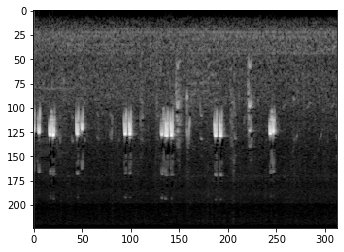

Label: tensor([13])


In [21]:
train_features, train_labels = next(iter(train_dataloader))
# train_features.squeeze_().swapaxes_(0, 1).swapaxes_(0, 2)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
idx = 30
img = train_features[idx].squeeze()
label = train_labels[idx]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Model architecture

In [32]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)

        tmp = torch.cos(position * div_term)
        
        if (d_model % 2 == 0):
            pe[:, 0, 1::2] = tmp
        else:
            # FIXME make sure that it makes sense to delete last entry of array
            pe[:, 0, 1::2] = tmp[:, :-1]

        
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [11]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, n_classes: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, d_model)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        # src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

class Net(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, n_classes: int, dropout: float = 0.5):
        super().__init__()
        self.transformer = TransformerModel(ntoken =  ntoken,
                            d_model = d_model,
                            nhead = nhead,
                            d_hid = d_hid,
                            nlayers = nlayers,
                            n_classes = n_classes)#.to(device)
                
        self.linear = nn.Linear(ntoken * d_model, n_classes)

    def forward(self, x: Tensor) -> Tensor:
        x = self.transformer(x)
        # pool over d_model
        
        x.swapaxes_(0, 1)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return F.softmax(x)


# preprocess a 5-second chunk
train_features, train_labels = next(iter(train_dataloader))
train_features.squeeze_()
print(f"Feature batch shape: {train_features.size()}")
ntoken = 313#train_features.size()[2]
d_model = train_features.size()[1]

n_classes = len(dataframe.primary_label.unique())
d_hid = 200 # dimension of the feed-forward network model in nn.TransformerEncoder
nlayers = 1 # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 1 # number of heads in nn.MultiheadAttention
dropout = 0.2 # dropout probability
print(f"ntoken {ntoken}, d_model {d_model}")
model = Net(ntoken =  ntoken,
                        d_model = d_model,
                        nhead = nhead,
                        d_hid = d_hid,
                        nlayers = nlayers,
                        n_classes = n_classes).to(device)
model

Feature batch shape: torch.Size([128, 224, 313])
ntoken 313, d_model 224


Net(
  (transformer): TransformerModel(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=224, out_features=224, bias=True)
          )
          (linear1): Linear(in_features=224, out_features=200, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=200, out_features=224, bias=True)
          (norm1): LayerNorm((224,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((224,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
      )
    )
    (decoder): Linear(in_features=224, out_features=224, bias=True)
  )
  (linear): Linear(in_features=70112, out_features=15

In [37]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.global_average = nn.AvgPool2d((3, 3))
        self.fc1 = nn.Linear(6800, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.global_average(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

n_classes = len(dataframe.primary_label.unique())
model = CNN(n_classes).to(device)
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (global_average): AvgPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0)
  (fc1): Linear(in_features=6800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=152, bias=True)
)

In [38]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [44]:
losses = []
val_losses = []

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0    
    running_loss_count = 0

    model.train()     # Optional when not using Model Specific layer
    for inputs, labels in train_dataloader:
        # inputs, labels = data
        if device.type == 'cuda':
            inputs, labels = inputs.cuda(), labels.cuda()
        # inputs.squeeze_().swapaxes_(0, 1).swapaxes_(0, 2)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()

        losses.append(loss)

        running_loss += loss.item()
        running_loss_count += 1



    print(f'[{epoch + 1}] loss: {running_loss / running_loss_count:.3f}')
    running_loss = 0.0
    running_loss_count = 0

print('Finished Training')

[1] loss: 4.403
[2] loss: 4.191
[3] loss: 4.007
[4] loss: 3.815
[5] loss: 3.573
[6] loss: 3.345
[7] loss: 3.102
[8] loss: 2.897
[9] loss: 2.728
[10] loss: 2.531
Finished Training


In [48]:
val_running_loss = 0.0
val_running_loss_count = 0
model.eval()     # Optional when not using Model Specific layer
for inputs, labels in val_dataloader:
    # inputs, labels = data
    if device.type == 'cuda':
        inputs, labels = inputs.cuda(), labels.cuda()

    with torch.no_grad():
        target = model(inputs)
        val_loss = criterion(target, labels.squeeze())
        val_losses.append(val_loss)

        val_running_loss += val_loss.item()
        val_running_loss_count += 1

print(f'[{epoch + 1}] val loss: {val_running_loss / val_running_loss_count:.3f}')
val_running_loss = 0.0
val_running_loss_count = 0

RuntimeError: CUDA out of memory. Tried to allocate 100.00 MiB (GPU 0; 7.76 GiB total capacity; 4.89 GiB already allocated; 74.94 MiB free; 5.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

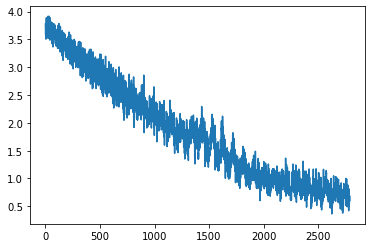

In [19]:
plt.plot(np.arange(len(losses)), list(map(lambda x: x.cpu().detach().numpy(), losses)))

In [ ]:
f1score = f1_score(y_test, np.round(preds), average="micro")
print(f1score)

In [ ]:
birdclef_dir = "/kaggle/input/birdclef-2022/"

with open(birdclef_dir + "scored_birds.json") as fp:
    scored_birds = json.load(fp)
    
print(scored_birds)

In [ ]:
def eval_test_file(filedir, filename):
    data = []
    audio, sample_rate = librosa.load(filedir + filename)
    num_chunks = math.ceil(len(audio) / (sample_rate * 5))
    for chunk in range(num_chunks):
        starting_second = chunk * 5
        ending_second = (chunk + 1) * 5
        audio_chunk = audio[(sample_rate * starting_second):(sample_rate * ending_second)]
        pred = round(xg_reg.predict([audio_chunk])[0])
        bird_id = le.inverse_transform([pred])[0]
        for bird in scored_birds:
            row_id = filename[:-4] + "_" + bird + "_" + str(ending_second)
            result = bird == bird_id
            data.append((row_id, result))
    return data

test_data_path = birdclef_dir + "test_soundscapes/"
out = eval_test_file(test_data_path, "soundscape_453028782.ogg")
out_df = pd.DataFrame(out, columns=["row_id","result"])
out_df.head()

In [ ]:
test_data_path = birdclef_dir + "test_soundscapes/"
filenames = sorted(os.listdir(test_data_path))
data = []
for filename in filenames:
    data += eval_test_file(test_data_path, filename)
test_df = pd.DataFrame(sorted(data), columns=['row_id', 'result'])
test_df.to_csv("submission.csv", index=False)